# Spectral manipulation with specutils

Astroconda environment (stsci package) as of November 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum, find_lines_derivative, find_lines_threshold
from specutils.manipulation import box_smooth, gaussian_smooth, trapezoid_smooth, extract_region
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler

import astropy
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.nddata import StdDevUncertainty
from astropy.modeling.polynomial import Chebyshev1D


Check versions

In [2]:
print("pandas:",pd.__version__)
print("astropy:",astropy.__version__)
print("specutils:",specutils.__version__)

pandas: 1.1.3
astropy: 4.0.2
specutils: 1.1


I do not have the spectrum Jane was using so I use another with similar very strong emission lines. It is z~6 model SED I created following Pacifici et al. 2012.

In [3]:
filename = 'Example_data/z6.dat'
sed = pd.read_csv(filename, sep='\s+')
sed

,wave(um),flux(mJy),ABmag
0,0.0705,0.000000,inf
1,0.0711,0.000000,inf
2,0.0717,0.000000,inf
3,0.0724,0.000000,inf
4,0.0730,0.000000,inf
...,...,...,...
11278,67.3400,0.000016,28.366
11279,67.6200,0.000016,28.361
11280,67.9000,0.000016,28.356
11281,68.1800,0.000017,28.353


In [4]:
quantity_support()  # for getting units on the axes 
zz = 6.

**Documentation:**

Spectrum1D object:
https://specutils.readthedocs.io/en/stable/spectrum1d.html

Custom loaders could also be created:
https://specutils.readthedocs.io/en/stable/custom_loading.html

**Dev note:**

Pandas is not an option yet. It would be nice to have that too. Ticket filed here:  https://github.com/astropy/specutils/issues/740#issuecomment-740190980

Jane comment: Actually, Pandas Series are at the heart Numpy arrays so they would work (see my ticket), except that Astropy's type checking bans them.

In [7]:
#Create the Spectrum1D object - including uncertainty
spec1d = Spectrum1D(spectral_axis = sed['wave(um)'].values * u.um, 
                    flux=sed['flux(mJy)'].values * u.Unit('mJy'), 
                    uncertainty=StdDevUncertainty((0.05*sed['flux(mJy)'].values) * u.Unit('mJy')),
                    redshift=zz) 

In [8]:
#Create another Spectrum1D at rest-frame
spec1d_rest = Spectrum1D(spectral_axis = sed['wave(um)'].values / (1.+zz) * u.um, 
                    flux=sed['flux(mJy)'].values / (1.+zz) * u.Unit('mJy'), 
                    uncertainty=StdDevUncertainty((0.05*sed['flux(mJy)'].values) / (1.+zz) * u.Unit('mJy'))) 

**Dev note:**

It would be ideal to have specutils take care of the observer frame to rest frame conversion. Ticket filed here: https://github.com/astropy/specutils/issues/741

Plot the spectrum.

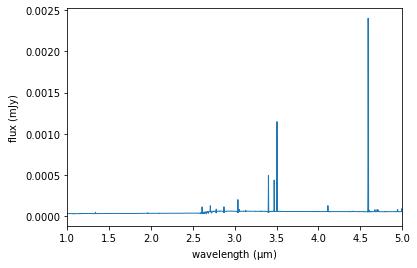

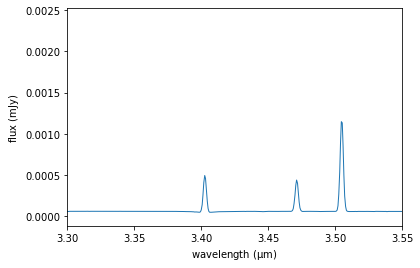

In [9]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.xlim(1,5)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()

#with a zoom in on Hb and [OIII]
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.xlim(3.3,3.55)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()

I want to use fit_generic_continuum. Here is the documentation:

https://specutils.readthedocs.io/en/stable/fitting.html

But it does not talk about the limitations of such generic function. The given examples are however quite simple and the functionality is defined as "Basic fitting of the continuum".

Not clear what is the difference between fit_continuum and fit_generic_continuum. Example is outdated with the "window" keyword. This version needs "exclude_regions". Will file ticket.

I will first select a region with SpectralRegion. From the documentation: "Spectral regions can be defined either as a single region by passing two Quantity’s or by passing a list of 2-tuples. Note that the units of these quantites can be any valid spectral unit or u.pixel (which indicates to use indexing directly)."
https://specutils.readthedocs.io/en/stable/spectral_regions.html

In [8]:
#regions to be excluded
region = SpectralRegion([(0.07*u.um,1.5*u.um),(4.7*u.um,70*u.um)])
#fit generic continuum
continuum = fit_generic_continuum(spec1d,exclude_regions=region)
spec1d_cont =  continuum(spec1d.spectral_axis)  

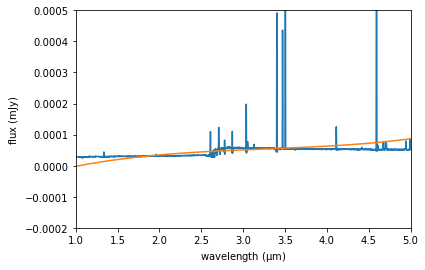

In [9]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.plot(spec1d.spectral_axis,spec1d_cont)
plt.xlim(1,5)
plt.ylim(-0.0002,0.0005)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


With the emission lines and the 4000A break, a single function for the whole continuum is not optimal. Lets see how it works on a smaller part of the spectrum

In [10]:
#regions to be excluded
region_small = SpectralRegion([(0.07*u.um,3.3*u.um),(3.6*u.um,70*u.um)])
#fit generic continuum
continuum_small = fit_generic_continuum(spec1d,exclude_regions=region_small,model=Chebyshev1D(1))
spec1d_cont_small =  continuum_small(spec1d.spectral_axis)  

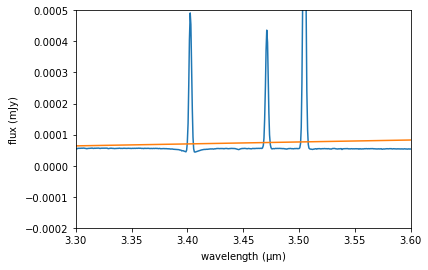

In [11]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.plot(spec1d.spectral_axis,spec1d_cont_small)
plt.xlim(3.3,3.6)
plt.ylim(-0.0002,0.0005)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


The emission lines should be masked. I will just cut also that region.

In [12]:
#regions to be excluded - also the block with the strong emission lines
region_small_nolines = SpectralRegion([(0.07*u.um,3.3*u.um),(3.38*u.um,3.52*u.um),(3.6*u.um,70*u.um)])
#fit generic continuum
continuum_small_nolines = fit_generic_continuum(spec1d,exclude_regions=region_small_nolines,model=Chebyshev1D(1))
spec1d_cont_small_nolines =  continuum_small_nolines(spec1d.spectral_axis)  

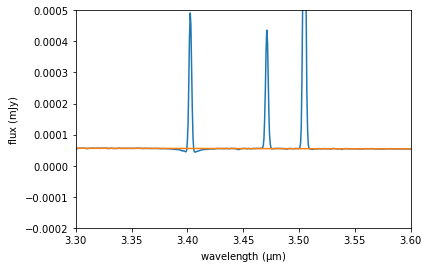

In [13]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.plot(spec1d.spectral_axis,spec1d_cont_small_nolines)
plt.xlim(3.3,3.6)
plt.ylim(-0.0002,0.0005)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


**Dev note**

It should be made clear in the documentation that fit_generic_continuum works optimally on small wavelength ranges.

I can try the area around [OII] that is generally more complex.

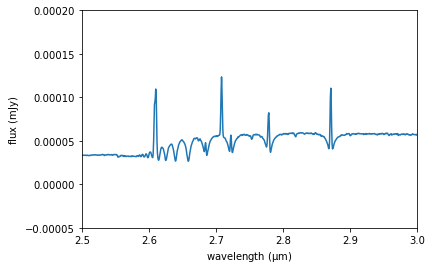

In [14]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.xlim(2.5,3.0)
plt.ylim(-0.00005,0.0002)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


In [15]:
#regions to be excluded
region_oii = SpectralRegion([(0.07*u.um,2.5*u.um),(2.6*u.um,2.61*u.um),(3.0*u.um,70*u.um)])
#fit generic continuum - with higher order for the fitting function
continuum_oii = fit_generic_continuum(spec1d,exclude_regions=region_oii,model=Chebyshev1D(4))
spec1d_cont_oii =  continuum_oii(spec1d.spectral_axis)  

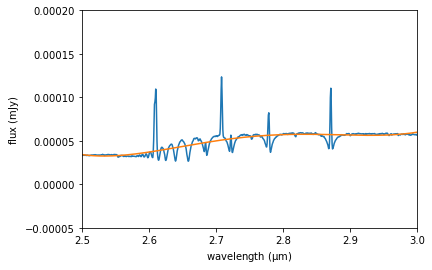

In [16]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.plot(spec1d.spectral_axis,spec1d_cont_oii)
plt.xlim(2.5,3.0)
plt.ylim(-0.00005,0.0002)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


This is not too bad. I had to increase the order of the polynomial used for the fitting here.

In this case, I know the redshift, so I know where the interesting features are. If I did not know the redshift, I could find lines using a function. There are two options.

https://specutils.readthedocs.io/en/stable/api/specutils.fitting.find_lines_derivative.html#specutils.fitting.find_lines_derivative

https://specutils.readthedocs.io/en/stable/api/specutils.fitting.find_lines_threshold.html#specutils.fitting.find_lines_threshold

Find_lines_derivative is based on finding the zero crossing in the derivative of the spectrum (https://specutils.readthedocs.io/en/stable/api/specutils.fitting.find_lines_derivative.html#specutils.fitting.find_lines_derivative) which works well on models. Find_lines_threshold works better for observations with uncertanties.

In [17]:
#specutils.conf.do_continuum_function_check = False
lines = find_lines_derivative(spec1d, flux_threshold=0.0001)


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning.


In [18]:
lines

line_center,line_type,line_center_index
um,,
float64,str8,int64
2.61,emission,4031
2.7077,emission,4186
3.0378,emission,4710
3.4026,emission,5289
3.4712,emission,5398
3.5046,emission,5451
4.1126,emission,6416
4.5939,emission,7180


Let us quickly check those lines

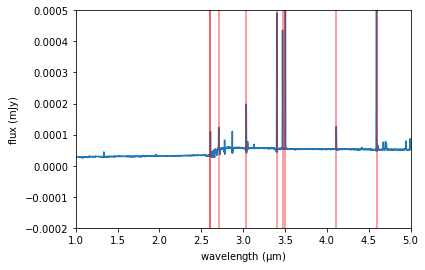

In [19]:
plt.plot(spec1d.spectral_axis,spec1d.flux,label="data")
plt.axvline(lines['line_center'][0].value, color="red", alpha=0.5, label='emission/absorption lines')
for line in lines:
    plt.axvline(line['line_center'].value, color='red', alpha=0.5)
plt.xlim(1,5)
plt.ylim(-0.0002,0.0005)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


Now I know the chunks I should avoid. But I did find before that the continuum can unlikely be represented with a single function. So what I would do is break the spectrum in chunks, fit the continuum there, and then recombine the spectrum and its continuum.

The functions to do that would be:

SpectralRegion to select the region: https://specutils.readthedocs.io/en/stable/spectral_regions.html

extract_region to get the part of the spectrum I care about:
https://specutils.readthedocs.io/en/stable/api/specutils.manipulation.extract_region.html

Then fit continuum like I did before.

Combine the continuum pieces:
https://specutils.readthedocs.io/en/stable/manipulation.html#splicing-combining-multiple-spectra

Another option is to smooth the spectrum with a large window to obtain a continuum.

This would require convolution functions like these:
https://specutils.readthedocs.io/en/stable/manipulation.html#smoothing

In [20]:
#gaussian smooth on the whole spectrum
spec1d_gsmooth = gaussian_smooth(spec1d, stddev=100)

/Users/cpacifici/miniconda3/envs/astroutils_nov/lib/python3.7/site-packages/specutils/manipulation/smoothing.py:62: RuntimeWarning: divide by zero encountered in true_divide
  ivar_values = 1 / values**2


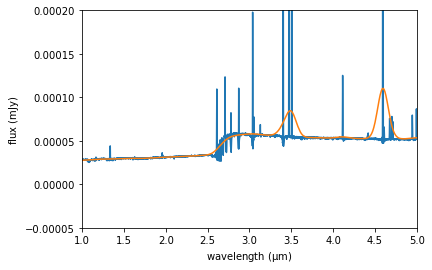

In [21]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.plot(spec1d_gsmooth.spectral_axis,spec1d_gsmooth.flux)
plt.xlim(1.,5.)
plt.ylim(-0.00005,0.0002)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


This is quite good! I need to just mask the super strong emission lines. Done ad hoc now, but I can surely use the lines found by the other function.

In [22]:
region_of_interest = SpectralRegion([(0.8*u.um,6.0*u.um)])
region_for_smooth = SpectralRegion([(0.8*u.um,3.49*u.um),(3.51*u.um,4.59*u.um),(4.6*u.um,6.0*u.um)])

In [23]:
spec1d_of_interest = extract_region(spec1d,region_of_interest)
spec1d_for_smooth = extract_region(spec1d,region_for_smooth)

#there are 3 regions in region_for_smooth so the spec1d_for_smooth has 3 spectrum1D objects
#this is clunky and there is a ticket to fix this
linear = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
spec1d_for_smooth0 = linear(spec1d_for_smooth[0],spec1d_of_interest.spectral_axis)
spec1d_for_smooth1 = linear(spec1d_for_smooth[1],spec1d_of_interest.spectral_axis)
spec1d_for_smooth2 = linear(spec1d_for_smooth[2],spec1d_of_interest.spectral_axis)

spec1d_for_smooth_comb = spec1d_for_smooth0 + spec1d_for_smooth1 + spec1d_for_smooth2

spec1d_interest_smooth = gaussian_smooth(spec1d_for_smooth_comb,stddev=100)

/Users/cpacifici/miniconda3/envs/astroutils_nov/lib/python3.7/site-packages/specutils/manipulation/smoothing.py:62: RuntimeWarning: divide by zero encountered in true_divide
  ivar_values = 1 / values**2


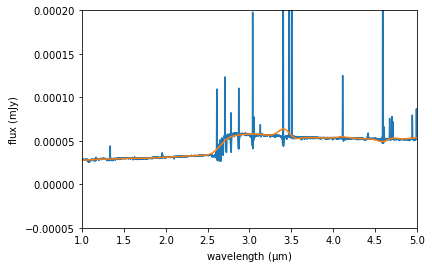

In [24]:
plt.plot(spec1d.spectral_axis,spec1d.flux)
plt.plot(spec1d_interest_smooth.spectral_axis,spec1d_interest_smooth.flux)
plt.xlim(1.,5.)
plt.ylim(-0.00005,0.0002)
plt.xlabel("wavelength ({:latex})".format(spec1d.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d.flux.unit))
plt.show()


This is not too bad and once the extract_region problem is fixed it will be a good alternative to fit_generic_continuum which is better on small parts of the spectrum. 